# 0.0. IMPORTS

## 0.1. Bibliotecas

In [563]:
import pandas as pd
import numpy as np
import os
import math

from unidecode import unidecode

import matplotlib.pyplot as plt

## 0.2. Carregar Dados

### 0.2.1. Escolas

In [564]:
diretorio_escolas = os.path.dirname(os.path.abspath('escolas.csv'))
caminho_escolas = os.path.join(diretorio_escolas, '../..', 'data', 'raw', 'escolas.csv')
df_escolas_raw = pd.read_csv(caminho_escolas)

### 0.2.2. Material Didatico

In [565]:
diretorio_material_didatico = os.path.dirname(os.path.abspath('material_didatico.csv'))
caminho_material_didatico = os.path.join(diretorio_material_didatico, '../..', 'data', 'raw', 'material_didatico.csv')
df_material_didatico_raw = pd.read_csv(caminho_material_didatico)

### 0.2.3. Sub-Prefeituras

In [566]:
diretorio_subprefeituras = os.path.dirname(os.path.abspath('subprefeituras.csv'))
caminho_subprefeituras = os.path.join(diretorio_subprefeituras, '../..', 'data', 'raw', 'subprefeituras.csv')
df_subprefeituras_raw = pd.read_csv(caminho_subprefeituras)

## 0.3. Funções

### 0.3.1. renomeia_colunas

In [567]:
def renomeia_colunas(data):
    return [x.lower().rstrip() for x in data.columns]

### 0.3.2. tamanho_dos_dados

In [568]:
def tamanho_dos_dados(data):
    print(f'Colunas: {data.shape[1]}')
    print(f'Linhas: {data.shape[0]}')

### 0.3.3. qtd_total_unicos_por_coluna

In [569]:
def qtd_total_unicos_por_coluna(data):
    for x in data.columns:
        print(f'Quantidade de valores unicos em {x}: {len(data[x].unique())}')

### 0.3.4. get_numericos

In [570]:
def get_numericos(data):
    return data.select_dtypes(include=['int32', 'int64', 'float32', 'float64'])

### 0.3.5. get_categoricos

In [571]:
def get_categoricos(data):
    return data.select_dtypes(exclude=['int32', 'int64', 'float32', 'float64', 'datetime64[ns]'])

### 0.3.6. get_descriptive_info

In [572]:
def get_descriptive_info(data):
    dados_numericos = get_numericos(data)
    
    # medidas de tendencia central - media, mediana
    df_media = pd.DataFrame(dados_numericos.apply(np.mean)).T
    df_mediana = pd.DataFrame(dados_numericos.apply(np.median)).T   
    
    # medidas de dispersão - min, max, range, skew, kurtosis, std
    df_std = pd.DataFrame(dados_numericos.apply(np.std)).T
    df_min = pd.DataFrame(dados_numericos.apply(min)).T
    df_max = pd.DataFrame(dados_numericos.apply(max)).T
    df_range = pd.DataFrame(dados_numericos.apply(lambda x: x.max() - x.min())).T
    df_skew = pd.DataFrame(dados_numericos.apply(lambda x: x.skew())).T
    df_kurtosis = pd.DataFrame(dados_numericos.apply(lambda x: x.kurtosis())).T
    
    #min, max, range, media, mediana, std, skew, kurtosis
    df_descriptive_info = pd.concat([df_min, df_max, df_range,
                                     df_media, df_mediana, df_std,
                                     df_skew, df_kurtosis]).T.reset_index()
    
    df_descriptive_info.columns = ['attributes', 'min', 'max',
                                   'range', 'media', 'mediana',
                                   'std', 'skew', 'kurtosis']
    
    return df_descriptive_info

### 0.3.7. salvar_dados_csv

In [573]:
def salvar_dados_csv(data, nome=''):
    data.to_csv(f'../../data/processed/{nome}', index=False )

### 0.3.8. remove_acentos

In [574]:
def remove_acentos(data):
    categoricos = get_categoricos(data)
    for column in categoricos.columns:        
        data[column] = data[column].apply(lambda x: unidecode(x))
    return data

### 0.3.9. string_maisculo

In [575]:
def string_maisculo(data):
    categoricos = get_categoricos(data)

    for column in categoricos:
        data[column] = data[column].str.upper()
        
    return data

### 0.3.10. remodelando_id

In [576]:
def remodelando_id(data):
    data['id'] = data['id'].astype(str).apply(lambda x: f'0{x}' if len(x) < 3 else f'{x}')
    return data

### 0.3.11. distance

In [577]:
def distance(point1, point2):
    """
    Calcula a distância entre dois pontos geográficos, usando a fórmula de Haversine.
    """
    lat1, lon1 = point1
    lat2, lon2 = point2
    R = 6371  # raio da Terra em quilômetros
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = (
        math.sin(delta_phi / 2) ** 2
        + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    d = R * c
    return d

### 0.3.12. nearest_neighbor

In [578]:
def nearest_neighbor(points):
    unvisited = set(
        range(1, len(points))
    )  # índices que representam os pontos não visitados
    current_point = 0
    route = [current_point]

    while unvisited:
        nearest = min(
            unvisited, key=lambda x: distance(points[current_point], points[x])
        )
        route.append(nearest)
        unvisited.remove(nearest)
        current_point = nearest

    route.append(0)  # Volta ao ponto inicial para fechar o ciclo
    return route

### 0.3.13. extrair_tipo_escola

In [579]:
def extrair_tipo_escola(texto):
    partes = texto.split()  
    return partes[0]  

### 0.3.14. extrair_nome_escola

In [580]:
def extrair_nome_escola(texto):
    indice_primeiro_espaco = texto.find(' ')  
    if indice_primeiro_espaco != -1:
        return texto[indice_primeiro_espaco+1:]
    else:
        return texto

### 0.3.15. extrair_numero

In [581]:
def extrair_numero(endereco):
    palavras = endereco.split()
    for palavra in palavras:
        if palavra.isdigit():
            return palavra
    return '9999'

# 1.0. DESCRIÇÃO DOS DADOS

## 1.1. Escolas

### 1.1.1. Visão Geral dos Dados

In [582]:
df1_escolas = df_escolas_raw.copy()

In [583]:
df1_escolas.head().T

,0,1,2,3,4
id,178,634,483,476,132
Escolas_Postos,CENTRO INTEGRADO DE EDUCAÇÃO PÚBLICA HENFIL,EM ALICE DO AMARAL PEIXOTO,EM CELESTINO SILVA,ESCOLA MUNICIPAL FLORIANO PEIXOTO,EM PEREIRA PASSOS
BAIRRO,CAJU,BENFICA,CENTRO,SÃO CRISTÓVÃO,RIO COMPRIDO
ENDEREÇO,Rua Carlos Seidl S/Nº,Rua Ébano 187,"R. do Lavradio, 56",Praça Argentina 20,Praça Condessa Paulo de Frontin 45
lat,"-22,880888","-22,889574","-22,909293","-22,897629","-22,924412"
lon,"-43,225326","-43,236202","-43,183579","-43,227456","-43,208579"


In [584]:
df1_escolas.columns = renomeia_colunas(df1_escolas)

In [585]:
df1_escolas.columns

Index(['id', 'escolas_postos', 'bairro', 'endereço', 'lat', 'lon'], dtype='object')

### 1.1.2. Tamanho dos dados

In [586]:
tamanho_dos_dados(df1_escolas)

Colunas: 6
Linhas: 152


In [587]:
qtd_total_unicos_por_coluna(df1_escolas)

Quantidade de valores unicos em id: 136
Quantidade de valores unicos em escolas_postos: 136
Quantidade de valores unicos em bairro: 90
Quantidade de valores unicos em endereço: 137
Quantidade de valores unicos em lat: 136
Quantidade de valores unicos em lon: 135


### 1.1.3. Verificar Nulos

In [588]:
df1_escolas.isna().sum()

id                0
escolas_postos    0
bairro            0
endereço          0
lat               0
lon               0
dtype: int64

### 1.1.4. Verificar tipos dos dados

In [589]:
df1_escolas.dtypes

id                 int64
escolas_postos    object
bairro            object
endereço          object
lat               object
lon               object
dtype: object

### 1.1.5. Verificar dados duplicados

In [590]:
df1_escolas.duplicated().sum()

13

### 1.1.6. Tratamento Inicial

In [591]:
df1_escolas = df1_escolas.drop_duplicates()

In [592]:
df1_escolas

,id,escolas_postos,bairro,endereço,lat,lon
0,178,CENTRO INTEGRADO DE EDUCAÇÃO PÚBLICA HENFIL,CAJU,Rua Carlos Seidl S/Nº,"-22,880888","-43,225326"
1,634,EM ALICE DO AMARAL PEIXOTO,BENFICA,Rua Ébano 187,"-22,889574","-43,236202"
2,483,EM CELESTINO SILVA,CENTRO,"R. do Lavradio, 56","-22,909293","-43,183579"
3,476,ESCOLA MUNICIPAL FLORIANO PEIXOTO,SÃO CRISTÓVÃO,Praça Argentina 20,"-22,897629","-43,227456"
4,132,EM PEREIRA PASSOS,RIO COMPRIDO,Praça Condessa Paulo de Frontin 45,"-22,924412","-43,208579"
...,...,...,...,...,...,...
146,210,EM DEBORA MENDES DE MORAES,PEDRA DE GUARATIBA,Rua Belchior Da Fonseca 643,"-23,001416","-43,638757"
147,474,EM ENGENHEIRO GASTÃO RANGEL,GUARATIBA,Estrada Do Magarça 9.183,"-22,98046","-43,643545"
148,301,EM JONATAS SERRANO,GUARATIBA,"Estrada Do Mato Alto, S/Nº","-22,953163","-43,577409"
149,215,E.M. NARCISA AMALIA,ILHA DE GUARATIBA,Estrada Teodoreto de Camargo S/N.º,"-23,009084","-43,537582"


In [593]:
#Transformando as coordenadas de strings para floats

df1_escolas['lat'] = df1_escolas['lat'].str.replace(',', '.')
df1_escolas['lat'] = pd.to_numeric(df1_escolas['lat']).round(5)

df1_escolas['lon'] = df1_escolas['lon'].str.replace(',', '.')
df1_escolas['lon'] = pd.to_numeric(df1_escolas['lon']).round(5)

df1_escolas.dtypes

id                  int64
escolas_postos     object
bairro             object
endereço           object
lat               float64
lon               float64
dtype: object

In [594]:
df1_escolas = remove_acentos(df1_escolas)

In [595]:
df1_escolas = remodelando_id(df1_escolas)

In [596]:
df1_escolas = string_maisculo(df1_escolas)

In [597]:
tamanho_dos_dados(df1_escolas)

Colunas: 6
Linhas: 139


In [598]:
#Tratamento dos dados de Logradouro

df1_escolas['endereço'] = df1_escolas['endereço'].str.replace("R.", "RUA")
df1_escolas['endereço'] = df1_escolas['endereço'].str.replace("S/NO", "SEM NUMERO")
df1_escolas['endereço'] = df1_escolas['endereço'].str.replace("S/N.O", "SEM NUMERO")
df1_escolas['endereço'] = df1_escolas['endereço'].str.replace(",", "")
df1_escolas['endereço'] = df1_escolas['endereço'].str.replace(".", "")
df1_escolas['endereço'] = df1_escolas['endereço'].str.replace("S/NDEG", "SEM NUMERO")
df1_escolas['endereço'] = df1_escolas['endereço'].str.replace("PCA", "PRAÇA")
df1_escolas['endereço'] = df1_escolas['endereço'].str.replace("AV", "AVENIDA")

### 1.1.6. Salvar dados

In [599]:
salvar_dados_csv(df1_escolas, 'df1_escolas_descricao_dados.csv')

## 1.2. Material Didatico

### 1.2.1. Visão Geral dos Dados

In [600]:
df1_material_didatico = df_material_didatico_raw.copy()

In [601]:
df1_material_didatico.head().T

,0,1,2,3,4
id,178,634,483,476,132
Quantidade,20,121,220,190,67


In [602]:
df1_material_didatico.columns = renomeia_colunas(df1_material_didatico)

### 1.2.2. Tamanho dos dados

In [603]:
tamanho_dos_dados(df1_material_didatico)

Colunas: 2
Linhas: 151


In [604]:
qtd_total_unicos_por_coluna(df1_material_didatico)

Quantidade de valores unicos em id: 151
Quantidade de valores unicos em quantidade: 135


### 1.2.3. Verificar Nulos

In [605]:
df1_material_didatico.isna().sum()

id            0
quantidade    4
dtype: int64

### 1.2.4. Verificar tipos dos dados

In [606]:
df1_material_didatico.dtypes

id             int64
quantidade    object
dtype: object

### 1.2.5. Verificar dados duplicados

In [607]:
df1_material_didatico.duplicated().sum()

0

In [608]:
df1_material_didatico

,id,quantidade
0,178,20
1,634,121
2,483,220
3,476,190
4,132,67
...,...,...
146,474,320
147,301,335
148,215,NaN
149,606,521


### 1.2.6. Tratamento Inicial

In [609]:
df1_material_didatico['quantidade'].unique()

array(['20', '121', '220', '190', '67', '397', '92', '578', '591', '473',
       '456', '223', '420', '573', "''", '366', '516', '319', '308',
       '111', '48', '525', '445', '164', '293', '152', '399', '185',
       '576', '63', '491', "'NaN'", '336', '159', '342', '262', '440',
       '365', nan, '183', '297', '44', '109', '350', '255', '457', '493',
       '489', '64', '530', '158', '123', '468', '234', '24', '218', '151',
       '564', '504', '61', '426', '167', '509', '292', '210', '153',
       "'397'", '41', '561', '180', '257', '260', '317', '345', '32',
       '513', '338', '416', '352', '393', '425', '136', "'395'", '115',
       '534', '430', '466', '51', '26', '94', '128', '520', '524', '279',
       '161', '179', '194', '599', '315', '435', '400', '294', '148',
       '269', '571', '235', '187', '392', '362', '71', '221', '372',
       '479', '99', '157', '296', '330', '316', '106', '207', '459',
       '537', '162', '579', '517', "' '", '135', '118', '341', '329',
     

In [610]:
df1_material_didatico['quantidade'] = df1_material_didatico['quantidade'].str.replace("'", "")
df1_material_didatico['quantidade'] = df1_material_didatico['quantidade'].replace(" ", np.nan)
df1_material_didatico['quantidade'] = df1_material_didatico['quantidade'].replace('NaN', np.nan)

# Converter a coluna 'quantidade' para tipo numérico
df1_material_didatico['quantidade'] = pd.to_numeric(df1_material_didatico['quantidade'])

moda = df1_material_didatico['quantidade'].value_counts().idxmax()
df1_material_didatico['quantidade'] = df1_material_didatico['quantidade'].fillna(moda)


# Verificar se as correções foram aplicadas corretamente
print(df1_material_didatico['quantidade'].unique())


[ 20. 121. 220. 190.  67. 397.  92. 578. 591. 473. 456. 223. 420. 573.
 342. 366. 516. 319. 308. 111.  48. 525. 445. 164. 293. 152. 399. 185.
 576.  63. 491. 336. 159. 262. 440. 365. 183. 297.  44. 109. 350. 255.
 457. 493. 489.  64. 530. 158. 123. 468. 234.  24. 218. 151. 564. 504.
  61. 426. 167. 509. 292. 210. 153.  41. 561. 180. 257. 260. 317. 345.
  32. 513. 338. 416. 352. 393. 425. 136. 395. 115. 534. 430. 466.  51.
  26.  94. 128. 520. 524. 279. 161. 179. 194. 599. 315. 435. 400. 294.
 148. 269. 571. 235. 187. 392. 362.  71. 221. 372. 479.  99. 157. 296.
 330. 316. 106. 207. 459. 537. 162. 579. 517. 135. 118. 341. 329. 570.
 320. 335. 521. 225.]


In [611]:
df1_material_didatico = remodelando_id(df1_material_didatico)
df1_material_didatico['id'].unique()

array(['178', '634', '483', '476', '132', '410', '055', '490', '600',
       '089', '387', '331', '450', '558', '413', '698', '540', '309',
       '268', '523', '017', '035', '011', '226', '638', '271', '126',
       '180', '163', '361', '280', '060', '587', '653', '660', '382',
       '217', '378', '429', '025', '367', '373', '624', '157', '020',
       '117', '502', '351', '135', '647', '440', '259', '422', '041',
       '537', '230', '683', '146', '566', '388', '498', '663', '121',
       '161', '263', '118', '140', '260', '236', '090', '274', '676',
       '390', '608', '589', '256', '091', '285', '248', '441', '623',
       '603', '673', '182', '520', '412', '031', '514', '023', '415',
       '016', '570', '528', '414', '690', '202', '550', '211', '526',
       '492', '466', '636', '527', '586', '080', '398', '175', '308',
       '512', '576', '495', '379', '641', '689', '171', '477', '206',
       '687', '568', '399', '255', '262', '633', '616', '320', '144',
       '534', '342',

In [612]:
len(df1_material_didatico['id'].unique())

151

### 1.2.7. Salvar dados

In [613]:
salvar_dados_csv(df1_material_didatico, 'df1_material_didatico_descricao_dados.csv')

## 1.3. Sub-Prefeituras

### 1.3.1. Visão Geral dos Dados

In [614]:
df1_subprefeituras = df_subprefeituras_raw.copy()

In [615]:
df1_subprefeituras.head(20)

,nome,subprefeitura
0,Santo Cristo,Centro
1,Gamboa,Centro
2,Saúde,Centro
3,Caju,Centro
4,Centro,Centro
5,Lapa,Centro
6,Rio Comprido,Centro
7,Cidade Nova,Centro
8,Catumbi,Centro
9,Estácio,Centro


### 1.3.2. Tamanho dos dados

In [616]:
tamanho_dos_dados(df1_subprefeituras)

Colunas: 2
Linhas: 164


In [617]:
qtd_total_unicos_por_coluna(df1_subprefeituras)

Quantidade de valores unicos em nome: 164
Quantidade de valores unicos em subprefeitura: 9


### 1.3.3. Verificar Nulos

In [618]:
df1_subprefeituras.isna().sum()

nome             0
subprefeitura    0
dtype: int64

### 1.3.4. Verificar tipos dos dados

In [619]:
df1_subprefeituras.dtypes

nome             object
subprefeitura    object
dtype: object

### 1.3.5. Verifica dados duplicados

In [620]:
df1_subprefeituras.duplicated().sum()

0

In [621]:
df1_subprefeituras

,nome,subprefeitura
0,Santo Cristo,Centro
1,Gamboa,Centro
2,Saúde,Centro
3,Caju,Centro
4,Centro,Centro
...,...,...
159,Santa Cruz,Zona Oeste
160,Guaratiba,Zona Oeste
161,Barra de Guaratiba,Zona Oeste
162,Pedra de Guaratiba,Zona Oeste


### 1.3.6. Tratamento Inicial

In [622]:
df1_subprefeituras['subprefeitura'] = df1_subprefeituras['subprefeitura'].str.upper()
df1_subprefeituras['nome'] = df1_subprefeituras['nome'].str.upper()

In [623]:
df1_subprefeituras.head().T

,0,1,2,3,4
nome,SANTO CRISTO,GAMBOA,SAÚDE,CAJU,CENTRO
subprefeitura,CENTRO,CENTRO,CENTRO,CENTRO,CENTRO


In [624]:
df1_subprefeituras = remove_acentos(df1_subprefeituras)

### 1.3.7. Salvar dados

In [625]:
salvar_dados_csv(df1_subprefeituras, 'df1_subprefeitura_descricao_dados.csv')

# 2.0. Feature Engineering

In [626]:
df2_escolas = df1_escolas.copy()
df2_material_didatico = df1_material_didatico.copy()
df2_subprefeituras = df1_subprefeituras.copy()

In [627]:
df2_escolas

,id,escolas_postos,bairro,endereço,lat,lon
0,178,CENTRO INTEGRADO DE EDUCACAO PUBLICA HENFIL,CAJU,RUA CARLOS SEIDL SEM NUMERO,-22.88089,-43.22533
1,634,EM ALICE DO AMARAL PEIXOTO,BENFICA,RUA EBANO 187,-22.88957,-43.23620
2,483,EM CELESTINO SILVA,CENTRO,RUA DO LAVENIDARADIO 56,-22.90929,-43.18358
3,476,ESCOLA MUNICIPAL FLORIANO PEIXOTO,SAO CRISTOVAO,PRACA ARGENTINA 20,-22.89763,-43.22746
4,132,EM PEREIRA PASSOS,RIO COMPRIDO,PRACA CONDESSA PAULO DE FRONTIN 45,-22.92441,-43.20858
...,...,...,...,...,...,...
146,210,EM DEBORA MENDES DE MORAES,PEDRA DE GUARATIBA,RUA BELCHIOR DA FONSECA 643,-23.00142,-43.63876
147,474,EM ENGENHEIRO GASTAO RANGEL,GUARATIBA,ESTRADA DO MAGARCA 9183,-22.98046,-43.64354
148,301,EM JONATAS SERRANO,GUARATIBA,ESTRADA DO MATO ALTO SEM NUMERO,-22.95316,-43.57741
149,215,E.M. NARCISA AMALIA,ILHA DE GUARATIBA,ESTRADA TEODORETO DE CAMARGO SEM NUMERO,-23.00908,-43.53758


In [628]:
df2_material_didatico

,id,quantidade
0,178,20.0
1,634,121.0
2,483,220.0
3,476,190.0
4,132,67.0
...,...,...
146,474,320.0
147,301,335.0
148,215,342.0
149,606,521.0


In [629]:
x = df2_material_didatico.sort_values(by='id')
for value in x['id']:
    print(value, end=' | ')

011 | 016 | 017 | 020 | 023 | 025 | 031 | 035 | 041 | 052 | 055 | 060 | 068 | 069 | 080 | 089 | 090 | 091 | 117 | 118 | 121 | 126 | 132 | 135 | 139 | 140 | 144 | 146 | 157 | 161 | 163 | 171 | 175 | 178 | 180 | 182 | 202 | 206 | 210 | 211 | 215 | 217 | 226 | 230 | 236 | 246 | 248 | 255 | 256 | 259 | 260 | 262 | 263 | 268 | 271 | 274 | 280 | 285 | 289 | 297 | 301 | 308 | 309 | 311 | 316 | 319 | 320 | 323 | 330 | 331 | 342 | 351 | 361 | 367 | 373 | 378 | 379 | 382 | 387 | 388 | 390 | 398 | 399 | 410 | 412 | 413 | 414 | 415 | 422 | 429 | 440 | 441 | 450 | 466 | 474 | 476 | 477 | 483 | 490 | 492 | 495 | 497 | 498 | 502 | 512 | 514 | 515 | 520 | 523 | 526 | 527 | 528 | 534 | 537 | 540 | 550 | 558 | 560 | 566 | 568 | 570 | 573 | 576 | 584 | 586 | 587 | 589 | 590 | 600 | 603 | 606 | 608 | 616 | 623 | 624 | 633 | 634 | 636 | 638 | 641 | 647 | 653 | 660 | 663 | 673 | 676 | 683 | 687 | 689 | 690 | 698 | 

In [630]:
df2_subprefeituras

,nome,subprefeitura
0,SANTO CRISTO,CENTRO
1,GAMBOA,CENTRO
2,SAUDE,CENTRO
3,CAJU,CENTRO
4,CENTRO,CENTRO
...,...,...
159,SANTA CRUZ,ZONA OESTE
160,GUARATIBA,ZONA OESTE
161,BARRA DE GUARATIBA,ZONA OESTE
162,PEDRA DE GUARATIBA,ZONA OESTE


## 2.1. Merge dos dados

In [631]:
df2_merged = pd.merge(df2_escolas, df2_subprefeituras, left_on='bairro', right_on='nome', how='left')

In [632]:
df2_merged.sample(5).T

,44,89,127,88,54
id,351,550,311,202,146
escolas_postos,CENTRO INTEGRADO DE EDUCACAO PUBLICA VINICIUS ...,EM 25 DE ABRIL,EM PESTALOZZI,E.M. PROFESSOR TEOFILO MOREIRA DA COSTA,EM BERNARDO VASCONCELOS
bairro,JACARE,FREGUESIA JPA,SANTA CRUZ,VARGEM GRANDE,PENHA
endereço,AVENIDA DOM HELDER CAMARA 1715,RUA MAMORE 78,RUA SEVERIANO DAS CHAGAS SEM NUMERO,RUA ESPERANCA 387,PRAÇA SANTA ROSALIA 100
lat,-22.88532,-22.93816,-22.91572,-22.98173,-22.84563
lon,-43.2541,-43.34258,-43.67975,-43.49164,-43.28401
nome,JACARE,NaN,SANTA CRUZ,VARGEM GRANDE,PENHA
subprefeitura,ZONA NORTE,NaN,ZONA OESTE,BARRA DA TIJUCA,ZONA NORTE


In [633]:
df2_merged = pd.merge(df2_merged, df2_material_didatico, left_on='id', right_on='id', how='inner')

In [634]:
df2_merged.sample(5).T

,129,62,105,100,46
id,497,118,641,398,388
escolas_postos,E.M PROFESSORA LEILA MEHL MENEZES DE MATTOS,CENTRO INTEGRADO DE EDUCACAO PUBLICA ELIS REGINA,EM LAURO MULLER,EM LEONARDO DA VINCI,EM CARDEAL CAMARA
bairro,PACIENCIA,BONSUCESSO,PADRE MIGUEL,BANGU,PARADA DE LUCAS
endereço,AVENIDAENIDA MARIO PEREIRA DOS SANTOS SEM NUMERO,RUA PRINCIPAL SEM NUMERO,RUA ROSA DE ALMEIDA 113,RUA RENATO REBECCHI SEM NUMERO,RUA ANAMA 98
lat,-22.87319,-22.85783,-22.88207,-22.89253,-22.81527
lon,-43.62773,-43.24045,-43.44644,-43.47295,-43.30357
nome,PACIENCIA,BONSUCESSO,PADRE MIGUEL,BANGU,PARADA DE LUCAS
subprefeitura,ZONA OESTE,ZONA NORTE,GRANDE BANGU,GRANDE BANGU,ZONA NORTE
quantidade,517.0,210.0,269.0,315.0,504.0


## 2.2. Tratamento de Nulos

In [635]:
df2_merged.isna().sum()

id                0
escolas_postos    0
bairro            0
endereço          0
lat               0
lon               0
nome              9
subprefeitura     9
quantidade        0
dtype: int64

In [636]:
df2_merged[df2_merged['subprefeitura'].isna()].sort_values(by='bairro')

,id,escolas_postos,bairro,endereço,lat,lon,nome,subprefeitura,quantidade
113,262,CIEP HERIVELTO MARTINS,AUGUSTO VASCONCELOS,PRACA SANTO ANASTACIO S/N,-22.88649,-43.52880,NaN,NaN,221.0
90,550,EM 25 DE ABRIL,FREGUESIA JPA,RUA MAMORE 78,-22.93816,-43.34258,NaN,NaN,128.0
94,492,EM MENEZES CORTES,FREGUESIA JPA,PRACA JOSE ALVES DE AZEVEDO 43,-22.94266,-43.33897,NaN,NaN,342.0
29,060,ESCOLA MUNICIPAL BARAO HOMEM DE MELO,MARACANA/ TIJUCA,RUA ALM JOAO CANDIDO BRASIL 352,-22.91683,-43.23692,NaN,NaN,342.0
28,280,ESCOLA MUNICIPAL GENERAL HUMBERTO DE SOUZA MELLO,MARACANA/ VILA ISABEL,RUA OITO DE DEZEMBRO 275,-22.90982,-43.23939,NaN,NaN,491.0
131,068,EM WALQUIR PEREIRA,NOVA SEPETIBA,ESTRADA DE SEPETIBA S/N BLOCO 1,-22.95601,-43.68675,NaN,NaN,135.0
79,412,EM MOZART LAGO,OSWALDO CRUZ,RUA JOSE CARVALHO SALGADO SEM NUMERO,-22.87221,-43.35033,NaN,NaN,395.0
86,528,CIEP MARGARET MEE,RECREIO,RUA MINISTRO ALIOMAR BALEEIRO SEM NUMERO,-23.01981,-43.48172,NaN,NaN,51.0
87,414,EM CLAUDIO BESSERMAN VIANNA - BUSSUNDA,RIO DAS PEDRAS,ESTRADA DE JACAREPAGUA 3327,-22.97336,-43.32916,NaN,NaN,26.0


In [637]:
# id = 262 | AUGUSTO VASCONCELOS = NaN
df2_merged.loc[df2_merged['id'] == '262', 'nome'] = 'AUGUSTO VASCONCELOS'
df2_merged.loc[df2_merged['id'] == '262', 'subprefeitura'] = 'OUTRO'

# id = 550 | FREGUESIA JPA = FREGUESIA (JACAREPAGUA) | JACAREPAGUA
df2_merged.loc[df2_merged['id'] == '550', 'nome'] = 'FREGUESIA (JACAREPAGUA)'
df2_merged.loc[df2_merged['id'] == '550', 'subprefeitura'] = 'JACAREPAGUA'

# id = 492 | FREGUESIA JPA = FREGUESIA (JACAREPAGUA)
df2_merged.loc[df2_merged['id'] == '492', 'nome'] = 'FREGUESIA (JACAREPAGUA)'
df2_merged.loc[df2_merged['id'] == '492', 'subprefeitura']  = 'JACAREPAGUA'

# id = 060 | MARACANA/ TIJUCA = MARACANA
df2_merged.loc[df2_merged['id'] == '060', 'nome'] = 'MARACANA'
df2_merged.loc[df2_merged['id'] == '060', 'subprefeitura'] = 'GRANDE TIJUCA'

# id = 280 | MARACANA/ VILA ISABEL  MARACANA
df2_merged.loc[df2_merged['id'] == '280', 'nome'] = 'MARACANA'
df2_merged.loc[df2_merged['id'] == '280', 'subprefeitura'] = 'GRANDE TIJUCA'

# id = 068 | NOVA SEPETIBA = NaN
df2_merged.loc[df2_merged['id'] == '068', 'nome'] = 'NOVA SEPETIBA'
df2_merged.loc[df2_merged['id'] == '068', 'subprefeitura'] = 'OUTRO'

# id = 412 | OSWALDO CRUZ = OSVALDO CRUZ
df2_merged.loc[df2_merged['id'] == '412', 'nome'] = 'OSVALDO CRUZ'
df2_merged.loc[df2_merged['id'] == '412', 'subprefeitura']= 'ZONA NORTE'

# id = 528 | RECREIO = RECREIO DOS BANDEIRANTES
df2_merged.loc[df2_merged['id'] == '528', 'nome'] = 'RECREIO DOS BANDEIRANTES'
df2_merged.loc[df2_merged['id'] == '528', 'subprefeitura'] = 'BARRA DA TIJUCA'

# id = 414 | RIO DAS PEDRAS = NaN
df2_merged.loc[df2_merged['id'] == '414', 'nome'] = 'RIO DAS PEDRAS'
df2_merged.loc[df2_merged['id'] == '414', 'subprefeitura'] = 'OUTRO'

In [638]:
df2_merged[df2_merged['subprefeitura'].isna()].sort_values(by='bairro')

,id,escolas_postos,bairro,endereço,lat,lon,nome,subprefeitura,quantidade


## 2.3. Tratamendo de Duplicados

In [639]:
df2_merged = df2_merged.drop_duplicates(subset='id')

## 2.4. Salvar dados

In [640]:
df2_merged.sample(5).T

,98,57,47,118,23
id,586,498,440,342,638
escolas_postos,CIEP ANTONIO EVARISTO DE MORAES,EM CHILE,EM JOAQUIM RIBEIRO,E.M FERNANDO COSTA,E.M AZEVEDO SODRE
bairro,SENADOR CAMARA,OLARIA,INHAUMA,CAMPO GRANDE,PRACA DA BANDEIRA
endereço,AVENIDAENIDA DE SANTA CRUZ SEM NUMERO,PRAÇA BELMONTE 15,PRAÇA SOLDADO COSME DOS SANTOS 28,RUA JOSE ALBANO SEM NUMERO,RUA BARAO DE UBA 331
lat,-22.88179,-22.84858,-22.87757,-22.89036,-22.91545
lon,-43.48733,-43.26859,-43.28563,-43.59399,-43.21109
nome,SENADOR CAMARA,OLARIA,INHAUMA,CAMPO GRANDE,PRACA DA BANDEIRA
subprefeitura,GRANDE BANGU,ZONA NORTE,ZONA NORTE,ZONA OESTE,GRANDE TIJUCA
quantidade,194.0,61.0,530.0,296.0,293.0


In [641]:
salvar_dados_csv(df2_merged, 'df2_feature_engineering.csv')

# 3.0. Construção de Entrega

## 3.1. Entrega Quantidade de Material por Subprefeitura

In [642]:
# Quantidade de material escolar por subprefeitura
Qt_mat_subpre = df2_merged.groupby('subprefeitura').agg(sum_quantidade=("quantidade", "sum"))
Qt_mat_subpre = Qt_mat_subpre.reset_index()
Qt_mat_subpre

,subprefeitura,sum_quantidade
0,BARRA DA TIJUCA,266.0
1,CENTRO,2352.0
2,GRANDE BANGU,4321.0
3,GRANDE TIJUCA,2958.0
4,ILHAS,741.0
5,JACAREPAGUA,2897.0
6,OUTRO,382.0
7,ZONA NORTE,14564.0
8,ZONA OESTE,9137.0
9,ZONA SUL,4598.0


In [643]:
salvar_dados_csv(Qt_mat_subpre, 'Qt_mat_subpre.csv')

## 3.2. Entrega de dados Estruturados e Ordenados

### 3.2.1. Preparação

In [644]:
df2_merged = pd.merge(df2_merged, Qt_mat_subpre, on='subprefeitura', how='left')

In [645]:
# Crie cada DataFrame separadamente
df_id = pd.DataFrame(df2_merged['id'])
df_tipo_escolas = pd.DataFrame(df2_merged['escolas_postos'].apply(extrair_tipo_escola))
df_nome_escolas = pd.DataFrame(df2_merged['escolas_postos'].apply(extrair_nome_escola))
df_endereco = pd.DataFrame(df2_merged['endereço'])
df_numero = pd.DataFrame(df2_merged['endereço'].apply(extrair_numero))
df_bairro = pd.DataFrame(df2_merged['bairro'])
df_subprefeitura = pd.DataFrame(df2_merged['subprefeitura'])
df_lat = pd.DataFrame(df2_merged['lat'])
df_lon = pd.DataFrame(df2_merged['lon'])
df_qtd_material_didatico = pd.DataFrame(df2_merged['quantidade'])

# Agrupe todos os dataframes em apenas um
df_final = pd.concat([df_id, df_tipo_escolas, df_nome_escolas, df_endereco, df_numero, df_bairro, df_subprefeitura, df_lat, df_lon, df_qtd_material_didatico], axis=1)


df_final.columns = ['id', 'tipo_escola', 'nome_escola', 'endereço', 'numero', 'bairro', 'subprefeitura', 'lat', 'lon', 'qtd_material_didatico']
# Exiba o DataFrame final
df_final

,id,tipo_escola,nome_escola,endereço,numero,bairro,subprefeitura,lat,lon,qtd_material_didatico
0,178,CENTRO,INTEGRADO DE EDUCACAO PUBLICA HENFIL,RUA CARLOS SEIDL SEM NUMERO,9999,CAJU,CENTRO,-22.88089,-43.22533,20.0
1,634,EM,ALICE DO AMARAL PEIXOTO,RUA EBANO 187,187,BENFICA,CENTRO,-22.88957,-43.23620,121.0
2,483,EM,CELESTINO SILVA,RUA DO LAVENIDARADIO 56,56,CENTRO,CENTRO,-22.90929,-43.18358,220.0
3,476,ESCOLA,MUNICIPAL FLORIANO PEIXOTO,PRACA ARGENTINA 20,20,SAO CRISTOVAO,CENTRO,-22.89763,-43.22746,190.0
4,132,EM,PEREIRA PASSOS,PRACA CONDESSA PAULO DE FRONTIN 45,45,RIO COMPRIDO,CENTRO,-22.92441,-43.20858,67.0
...,...,...,...,...,...,...,...,...,...,...
131,210,EM,DEBORA MENDES DE MORAES,RUA BELCHIOR DA FONSECA 643,643,PEDRA DE GUARATIBA,ZONA OESTE,-23.00142,-43.63876,570.0
132,474,EM,ENGENHEIRO GASTAO RANGEL,ESTRADA DO MAGARCA 9183,9183,GUARATIBA,ZONA OESTE,-22.98046,-43.64354,320.0
133,301,EM,JONATAS SERRANO,ESTRADA DO MATO ALTO SEM NUMERO,9999,GUARATIBA,ZONA OESTE,-22.95316,-43.57741,335.0
134,215,E.M.,NARCISA AMALIA,ESTRADA TEODORETO DE CAMARGO SEM NUMERO,9999,ILHA DE GUARATIBA,ZONA OESTE,-23.00908,-43.53758,342.0


In [646]:
df_final.isna().sum()

id                       0
tipo_escola              0
nome_escola              0
endereço                 0
numero                   0
bairro                   0
subprefeitura            0
lat                      0
lon                      0
qtd_material_didatico    0
dtype: int64

In [647]:
df_final[df_final['subprefeitura'].isna()].sort_values(by='bairro')

,id,tipo_escola,nome_escola,endereço,numero,bairro,subprefeitura,lat,lon,qtd_material_didatico


### 3.2.2 Ordenação

In [648]:
pontos_entrega = list(df_final[['lat', 'lon']].itertuples(index=False, name=None))

In [649]:
best_route = nearest_neighbor(pontos_entrega)
print("Melhor rota:", best_route)

Melhor rota: [0, 1, 8, 3, 27, 28, 20, 26, 25, 24, 21, 23, 39, 41, 47, 43, 48, 62, 60, 57, 61, 59, 55, 51, 56, 53, 54, 58, 50, 73, 75, 45, 49, 64, 67, 81, 78, 72, 77, 63, 79, 90, 80, 101, 71, 69, 70, 68, 99, 76, 104, 106, 107, 89, 93, 92, 82, 83, 91, 88, 94, 85, 30, 29, 32, 15, 5, 14, 13, 17, 12, 19, 11, 2, 6, 7, 22, 9, 4, 18, 16, 10, 36, 37, 31, 42, 44, 46, 33, 40, 35, 34, 38, 74, 66, 65, 100, 103, 102, 105, 97, 98, 95, 96, 114, 110, 117, 108, 109, 116, 52, 111, 115, 112, 122, 127, 118, 120, 124, 121, 128, 123, 130, 129, 132, 131, 135, 133, 113, 87, 84, 134, 86, 126, 119, 125, 0]


In [650]:
df_ordered = df_final.reindex(best_route)

In [651]:
df_ordered

,id,tipo_escola,nome_escola,endereço,numero,bairro,subprefeitura,lat,lon,qtd_material_didatico
0,178,CENTRO,INTEGRADO DE EDUCACAO PUBLICA HENFIL,RUA CARLOS SEIDL SEM NUMERO,9999,CAJU,CENTRO,-22.88089,-43.22533,20.0
1,634,EM,ALICE DO AMARAL PEIXOTO,RUA EBANO 187,187,BENFICA,CENTRO,-22.88957,-43.23620,121.0
8,600,EM,URUGUAI,RUA ANA NERI 192,192,BENFICA,CENTRO,-22.89849,-43.23776,591.0
3,476,ESCOLA,MUNICIPAL FLORIANO PEIXOTO,PRACA ARGENTINA 20,20,SAO CRISTOVAO,CENTRO,-22.89763,-43.22746,190.0
27,280,ESCOLA,MUNICIPAL GENERAL HUMBERTO DE SOUZA MELLO,RUA OITO DE DEZEMBRO 275,275,MARACANA/ VILA ISABEL,GRANDE TIJUCA,-22.90982,-43.23939,491.0
...,...,...,...,...,...,...,...,...,...,...
86,690,ESCOLA,MUNICIPAL FINLANDIA,RUA IGARAPE-ACU,9999,CAMORIM,BARRA DA TIJUCA,-22.97199,-43.41011,94.0
126,497,E.M,PROFESSORA LEILA MEHL MENEZES DE MATTOS,AVENIDAENIDA MARIO PEREIRA DOS SANTOS SEM NUMERO,9999,PACIENCIA,ZONA OESTE,-22.87319,-43.62773,517.0
119,573,CENTRO,INTEGRADO DE EDUCACAO PUBLICA MAJOR MANUEL GOM...,RUA CABO SAULO DE VASCONCELOS SEM NUMERO,9999,PACIENCIA,ZONA OESTE,-22.88855,-43.63805,207.0
125,316,EM,PROFESSORA FLAVIA DOS SANTOS SOARES,RUA EUDALDO GOMES DA SILVA SEM NUMERO CONJ URU...,9999,PACIENCIA,ZONA OESTE,-22.91403,-43.65344,579.0


### 3.2.3 Salvar Dados

In [652]:
salvar_dados_csv(df_ordered, 'df_ordenado.csv')

## 4. Desafio 

In [653]:
diretorio = os.path.dirname(os.path.abspath('df_ordenado.csv'))
caminho = os.path.join(diretorio, '../..', 'data', 'processed', 'df_ordenado.csv')
df_desafio = pd.read_csv(caminho)

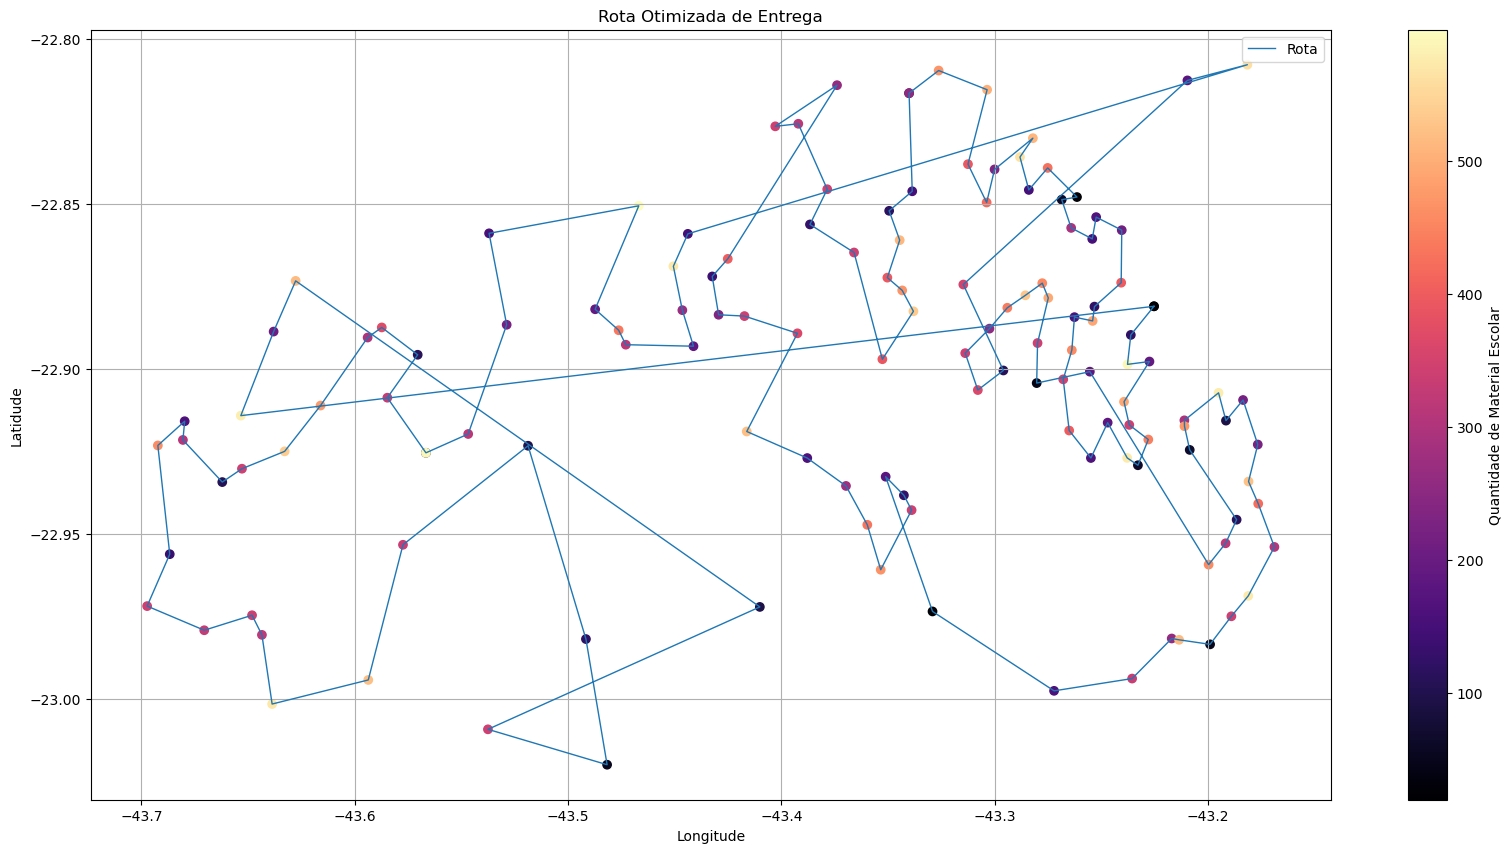

In [654]:
plt.figure(figsize=(20, 10))
lat = list(df_ordered['lat'])
lon = list(df_ordered['lon'])
qtd = list(df_ordered['qtd_material_didatico'])
plt.plot(lon, lat, '-', linewidth = 1)
plt.legend(['Rota','','',''])
plt.scatter(lon, lat, c = qtd, cmap = 'magma')
plt.colorbar(label = "Quantidade de Material Escolar")
plt.grid()
plt.title('Rota Otimizada de Entrega')
plt.xlabel('Longitude')
plt.ylabel('Latidude')
plt.show()